In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw

import seaborn as sns



from dateutil        import parser
from datetime import datetime

sns.set_context('poster')
sns.set_style('dark')

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


nc_file = nc.Dataset('/data/ssahu/ARIANE/LB_08/lot_of_particles_time_corrected.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [3]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time'][:]


final_age = nc_file.variables['final_age']


lon1=nc_file.variables['traj_lon'][:]
lat1=nc_file.variables['traj_lat'][:]
dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]

In [4]:
traj_depth.shape

(3921, 1504)

In [20]:
x1.shape

(1504,)

In [58]:
def plot_tracks():  
    
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]
    

    cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300
    
    import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

    for part in np.arange(x1.shape[0]):
        for k in np.arange(traj_depth.shape[0]):
            y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
            track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'red', alpha=0.9, edgecolor= 'orangered')
            q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=10, alpha=0.5)#, edgecolor= 'cyan')


    
    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)
    
    
#     ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,traj_depth_level])), fontsize =16)
    ax.legend(loc = 'best')
    
    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')
    
    ax.grid()
    
    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()



/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


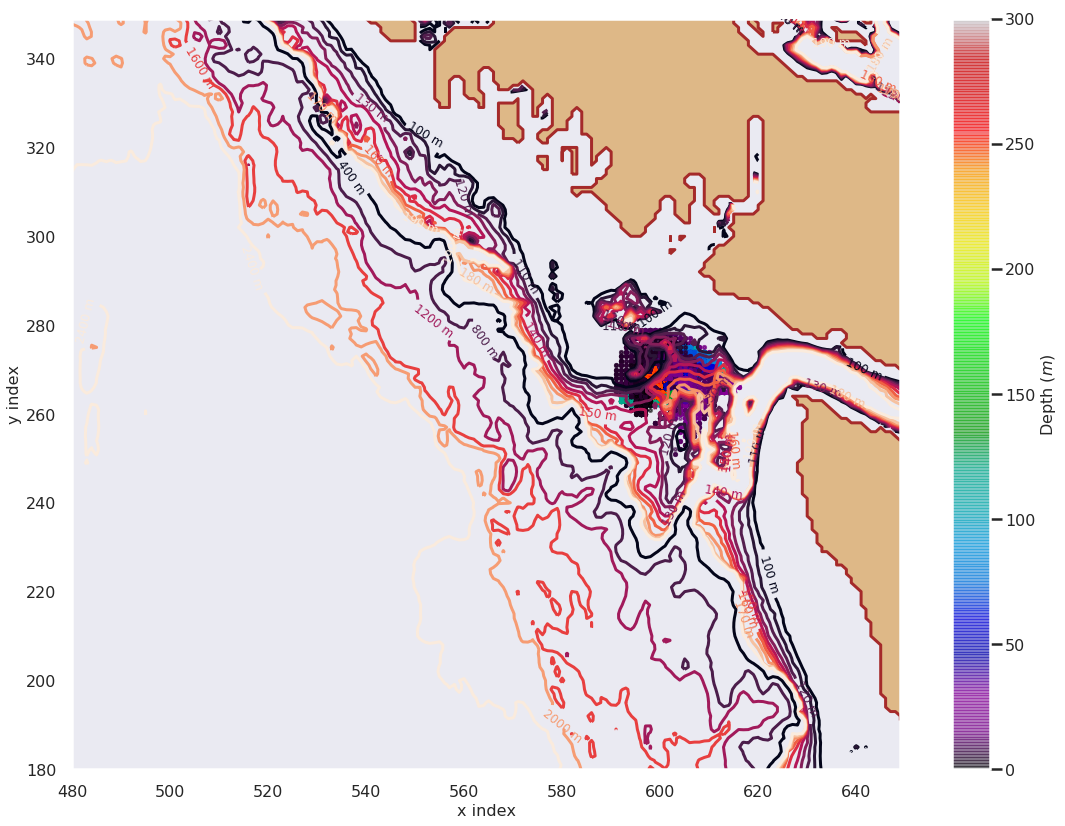

In [57]:
plot_tracks()

In [ ]:
plot_tracks()